In [1]:
import json
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
from torchvision.utils import draw_segmentation_masks
from IPython.display import display
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torch
from torchvision.io import decode_image
from torchvision.transforms.functional import resize
import attrs
from typing import Any


NUM_IMAGES = 100
TARGET_IMAGE_SIZE = [1024, 1024]
DATASET_DIR = Path("../../dataset/TextOCR")



In [2]:
# https://huggingface.co/datasets/yunusserhat/TextOCR-Dataset
tocr_json = json.load(open(DATASET_DIR / "TextOCR_0.1_train.json"))
# {
#   "imgs": {
#     "OpenImages_ImageID_1": {
#       "id": "OpenImages_ImageID_1",
#       "width":  W,
#       "height": H,
#       "set": "train|val|test",
#       "filename": "train|test/OpenImages_ImageID_1.jpg"
#     }
#   },
#   "anns": {
#     "OpenImages_ImageID_1_1": {
#       "id": "OpenImages_ImageID_1_1",
#       "image_id": "OpenImages_ImageID_1",
#       "bbox": [x1, y1, x2, y2],
#       "points": [x1, y1, x2, y2, ..., xN, yN],
#       "utf8_string": "text",
#       "area": A
#     }
#   },
#   "img2Anns": {
#     "OpenImages_ImageID_1": ["OpenImages_ImageID_1_1", "..."]
#   }
# }

In [15]:
@attrs.frozen
class DoctrDetSample:
    image_path: Path
    width: int
    height: int
    polygons: np.ndarray


class TextOCRDoctrDetDataset(Dataset[tuple[Tensor, dict[str, np.ndarray]]]):
    """Minimal TextOCR dataset wrapper emitting Doctr detection targets."""

    def __init__(
        self,
        images_dir: Path | None = None,
        json_path: Path | None = None,
        num_samples: int | None = None,
    ) -> None:
        base_images_dir = images_dir or (DATASET_DIR / "train_val_images")
        metadata_path = json_path or (DATASET_DIR / "TextOCR_0.1_train.json")

        with open(metadata_path) as fh:
            json_data = tocr_json or json.load(fh)

        self.samples: list[DoctrDetSample] = []
        max_labels, max_pts = self.get_max_dimensions(json_data)

        for img_id, ann_ids in json_data["imgToAnns"].items():
            if num_samples is not None and len(self.samples) >= num_samples:
                break

            img_meta = json_data["imgs"][img_id]
            width, height = img_meta["width"], img_meta["height"]

            polygons: np.ndarray = np.zeros((max_labels, max_pts, 2), dtype=np.float32)
            for i, ann_id in enumerate(ann_ids):
                ann = json_data["anns"][ann_id]
                raw_points: list[float] = ann["points"]

                if not raw_points:
                    continue
                    
                xs = np.array(raw_points[0::2], dtype=np.float32)
                ys = np.array(raw_points[1::2], dtype=np.float32)

                # Clip to image
                xs = np.clip(xs, 0.0, float(width))
                ys = np.clip(ys, 0.0, float(height))

                # Scale
                xs *= TARGET_IMAGE_SIZE[0]/width
                ys *= TARGET_IMAGE_SIZE[1]/height

                # Stack and pad to the max number of polygon points in dataset
                stacked = np.stack([xs,ys], axis=1)
                polygons[i] = np.pad(stacked, pad_width=((0, max_pts-len(xs)), (0, 0)))

            sample = DoctrDetSample(
                image_path=Path(base_images_dir) / img_meta["file_name"],
                width=width,
                height=height,
                polygons=polygons,
            )
            self.samples.append(sample)

        if not self.samples:
            raise ValueError(
                "No samples found. Ensure the TextOCR dataset is available at"
                f" {base_images_dir} and json at {metadata_path}"
            )

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> tuple[Tensor, dict[str, np.ndarray]]:
        sample = self.samples[idx]

        image = decode_image(str(sample.image_path))
        image = resize(image, list(TARGET_IMAGE_SIZE), antialias=True)
        image = image.to(torch.float32) / 255.0

        # Doctr expects a dict keyed by class name containing relative boxes in float32 numpy.
        target = {"words": sample.polygons.copy()}
        return image, target
    
    def get_max_dimensions(self, json_data: Any) -> tuple[int,int]:
        max_labels = 0
        for ann_ids in json_data["imgToAnns"].values():
            max_labels = max(max_labels, len(ann_ids))

        max_pts = 0
        for ann in json_data["anns"].values():
            max_pts = max(max_pts, len(ann['points']))

        return max_labels, max_pts


dataset = TextOCRDoctrDetDataset(num_samples=NUM_IMAGES)
loader = DataLoader(dataset, shuffle=True)


In [16]:
def clean_polygons(polys_p_n_2: torch.Tensor) -> list[Tensor]:
    """
    Remove zero-padded points from polygon tensors.
    polys_p_n_2: [P, N, 2]
    Returns: list of (N_i, 2) numpy arrays (valid polygons)
    """
    cleaned: list[Tensor] = []
    for poly in polys_p_n_2:
        # keep only points that are not [0,0]
        mask = ~torch.all(poly == 0, dim=-1)
        valid = poly[mask]
        if len(valid) >= 3:  # at least a triangle
            cleaned.append(valid)
    return cleaned

def overlay_polygons(image: torch.Tensor,
                     polygons: torch.Tensor,
                     alpha: float = 0.5) -> torch.Tensor:

    _, H, W = image.shape
    unpadded_polys = clean_polygons(polygons)
    if not unpadded_polys:
        return image

    masks = torch.zeros((len(unpadded_polys), H, W), dtype=torch.bool)
    for i, poly in enumerate(unpadded_polys):
        m = Image.new(mode="1", size=(W, H), color=0)
        d = ImageDraw.Draw(m)
        d.polygon([p.tolist() for p in poly], fill=1)
        masks[i] = torch.from_numpy(np.array(m, dtype=bool))

    colors = ["red", "lime", "blue", "yellow", "magenta", "cyan"]
    return draw_segmentation_masks(image, masks,
                                   colors=[colors[i % len(colors)] for i in range(len(unpadded_polys))],
                                   alpha=alpha)

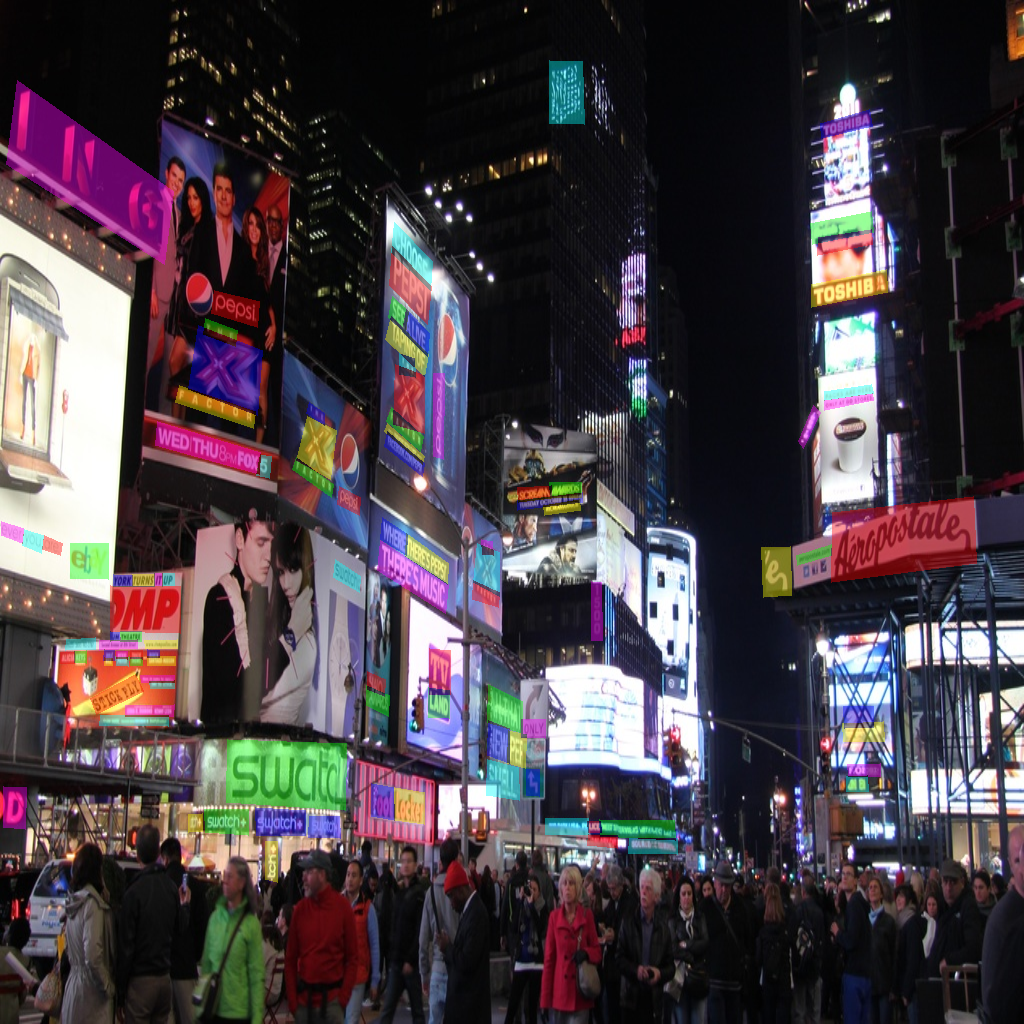

In [20]:
images, targets = next(iter(loader))

sample_image = images[0]
sample_polygons = targets['words'][0]

overlay = overlay_polygons(sample_image, sample_polygons, alpha=0.4)
display(to_pil_image(overlay))
